<a href="https://colab.research.google.com/github/HenryLimaa/Jobs/blob/main/DesafioPP_AB1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Desafio de Programação: Classificação de Pistas de Pouso em Imagens de Satélite**

## **Abordagem 1: Utilizando Google Earth Engine**

In [1]:
# @title Instalação de bibliotecas e do Google Earth Engine

!pip install earthengine-api > /dev/null
!pip install geemap tensorflow rasterio matplotlib scikit-learn numpy
!pip install segmentation_models_pytorch > /dev/null
!pip install sentinelhub > /dev/null
!pip install geopandas > /dev/null
!pip install shapely > /dev/null
!pip install scikit-image > /dev/null

print("Google Earth Engine API e demais bibliotecas instaladas!")

Google Earth Engine API e demais bibliotecas instaladas!


In [2]:
# Observação Geoespacial e da Terra
import ee
import geemap
import geopandas as gpd
from shapely.geometry import box
import rasterio
from rasterio.transform import from_origin
from sentinelhub import (
    SentinelHubRequest,
    DataCollection,
    MimeType,
    CRS,
    BBox,
    bbox_to_dimensions,
    SHConfig
)

# Aprendizado de máquina e aprendizado profundo
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
import torch
import segmentation_models_pytorch as smp
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Manipulação de Dados e Operações Numéricas
import numpy as np
import json

# Processamento e visualização de imagens
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# Bibliotecas e utilitários padrão
import os
import glob
import datetime
import random

# Ambiente Jupyter/IPython
import nbformat
from IPython.display import HTML, display

In [3]:
!earthengine authenticate

E0000 00:00:1758582178.455365    6849 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758582178.461863    6849 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758582178.478134    6849 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758582178.478181    6849 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758582178.478186    6849 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758582178.478190    6849 computation_placer.cc:177] computation placer already registered. Please check linka

In [4]:
    ee.Authenticate()
    ee.Initialize(project='my-earth-engine-project-472319')

    # Para utilizar outro projeto no Earth Engine mude o nome que está (my-earth-engine-project-472319) para o de prefeencia...
    # depois basta gerar o token de acesso e digita-lo no bloco 3

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


In [5]:
# @title Download da Imagem Sentinel-2

# Coordenadas da região de Altamira e sudoeste do Pará
min_lon, min_lat = -53.5, -4.5
max_lon, max_lat = -51.5, -3.0

# Criar geometria da região de interesse
roi = ee.Geometry.Rectangle([min_lon, min_lat, max_lon, max_lat])

# Definir intervalo de tempo (últimos 3 meses para melhor cobertura)
start_date = (datetime.date.today() - datetime.timedelta(days=90)).strftime('%Y-%m-%d')
end_date = datetime.date.today().strftime('%Y-%m-%d')


def mask_clouds(image):
    """Máscara de nuvens para Sentinel-2"""
    qa = image.select('QA60')
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11
    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(
           qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    return image.updateMask(mask).divide(10000)

def get_s2_image(roi, start_date, end_date):
    """Obtém imagem Sentinel-2 composta"""
    collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                 .filterBounds(roi)
                 .filterDate(start_date, end_date)
                 .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
                 .map(mask_clouds))

    # Criar composição mediana
    image = collection.median()

    # Selecionar bandas de interesse
    bands = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']  # Blue, Green, Red, NIR, SWIR1, SWIR2
    return image.select(bands)

# Obter imagem
s2_image = get_s2_image(roi, start_date, end_date)

print("Imagem Sentinel-2 carregada!")
print(f"Bandas disponíveis: {s2_image.bandNames().getInfo()}")

Imagem Sentinel-2 carregada!
Bandas disponíveis: ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']


In [6]:
# @title Configuração da Região - Sudoeste do Pará

# Coordenadas da região de Altamira e sudoeste do Pará
min_lon, min_lat = -53.5, -4.5
max_lon, max_lat = -51.5, -3.0

# Criar geometria da região de interesse
roi = ee.Geometry.Rectangle([min_lon, min_lat, max_lon, max_lat])

print("Região de estudo definida:")
print(f"   Latitude: {min_lat}° a {max_lat}°")
print(f"   Longitude: {min_lon}° a {max_lon}°")
print(f"   Área aproximada: {(max_lon-min_lon)*111*(max_lat-min_lat)*111:.0f} km²")

Região de estudo definida:
   Latitude: -4.5° a -3.0°
   Longitude: -53.5° a -51.5°
   Área aproximada: 36963 km²


In [7]:
# @title Configuração de Datas

# Definir intervalo de tempo (últimos 3 meses para melhor cobertura)
start_date = (datetime.date.today() - datetime.timedelta(days=90)).strftime('%Y-%m-%d')
end_date = datetime.date.today().strftime('%Y-%m-%d')

print(f"Período de análise: {start_date} a {end_date}")

Período de análise: 2025-06-24 a 2025-09-22


In [8]:
# @title Funções de Processamento para GEE

def calcular_ndvi(image):
    """Calcula NDVI para uma imagem do Sentinel-2"""
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

def aplicar_mascara_nuvens(image):
    """Aplica máscara de nuvens"""
    qa = image.select('QA60')
    # Bits 10 e 11 são nuvens e cirrus
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11
    mascara = qa.bitwiseAnd(cloud_bit_mask).eq(0) and qa.bitwiseAnd(cirrus_bit_mask).eq(0)
    return image.updateMask(mascara)

def obter_imagem_media(colecao):
    """Obtém imagem média da coleção"""
    return colecao.mean()

def converter_para_array(image, bandas, escala=1000):
    """Converte imagem do GEE para array numpy"""
    # Reduzir a região para obter array
    array = image.select(bandas).reduceRegion(
        reducer=ee.Reducer.toList(),
        geometry=roi,
        scale=escala,
        maxPixels=1e9
    ).getInfo()

    # Converter para numpy array
    bands_data = {}
    for banda in bandas:
        if banda in array:
            bands_data[banda] = np.array(array[banda])

    return bands_data

In [9]:
# @title Download de Imagens do Sentinel-2

try:
    # Carregar coleção do Sentinel-2
    colecao = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
        .filterBounds(roi) \
        .filterDate(start_date, end_date) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
        .map(aplicar_mascara_nuvens) \
        .map(calcular_ndvi)

    print(f"Número de imagens encontradas: {colecao.size().getInfo()}")

    # Obter imagem composta
    imagem_media = obter_imagem_media(colecao)

    # Selecionar bandas para RGB (B4, B3, B2 -> R, G, B)
    imagem_rgb = imagem_media.select(['B4', 'B3', 'B2'])
    imagem_ndvi = imagem_media.select('NDVI')

    print("Imagens processadas com sucesso!")

except Exception as e:
    print(f"Erro ao acessar GEE: {e}")
    print("Criando dados de exemplo para demonstração...")

    # Criar dados de exemplo
    altura, largura = 500, 600
    ndvi_image = np.random.rand(altura, largura) * 0.8 + 0.2

    # Simular características da região
    x, y = np.meshgrid(np.linspace(0, 1, largura), np.linspace(0, 1, altura))

    # Simular rio Xingu
    rio_mask = (np.abs(x - 0.5) < 0.05) & (np.abs(y - 0.5) < 0.8)
    ndvi_image[rio_mask] = -0.5

    # Simular áreas urbanas
    urbano_mask = (np.abs(x - 0.4) < 0.03) & (np.abs(y - 0.6) < 0.03)
    ndvi_image[urbano_mask] = 0.1

    # Criar RGB a partir do NDVI
    rgb_image = np.zeros((altura, largura, 3))
    rgb_image[ndvi_image > 0.6] = [0.1, 0.6, 0.1]    # Floresta densa
    rgb_image[ndvi_image > 0.3] = [0.3, 0.8, 0.3]    # Vegetação
    rgb_image[ndvi_image > 0.1] = [0.8, 0.9, 0.5]    # Vegetação esparsa
    rgb_image[ndvi_image <= 0.1] = [0.6, 0.6, 0.6]   # Áreas urbanas
    rgb_image[ndvi_image < 0] = [0.1, 0.2, 0.8]      # Água

    print("Dados de exemplo criados!")

Número de imagens encontradas: 47
Imagens processadas com sucesso!


In [10]:
# @title Visualização Interativa no Mapa

try:
    # Instalar geemap para visualização interativa
    !pip install geemap > /dev/null
    import geemap

    # Criar mapa interativo
    Map = geemap.Map(center=[(min_lat + max_lat)/2, (min_lon + max_lon)/2], zoom=9)

    # Adicionar camadas
    vis_params_rgb = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000, 'gamma': 1.4}
    vis_params_ndvi = {'bands': ['NDVI'], 'min': -1, 'max': 1, 'palette': ['red', 'yellow', 'green']}

    Map.addLayer(imagem_rgb, vis_params_rgb, 'Sentinel-2 RGB')
    Map.addLayer(imagem_ndvi, vis_params_ndvi, 'NDVI')
    Map.addLayer(roi, {'color': 'blue'}, 'Região de Estudo')

    # Exibir mapa
    print(" Mapa interativo criado! Use os controles para explorar.")
    display(Map)

except Exception as e:
    print(f"Erro ao criar mapa interativo: {e}")
    print("Continuando com visualização estática...")

 Mapa interativo criado! Use os controles para explorar.


Map(center=[-3.75, -52.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

...

Convertendo imagens em matrizes...
Estrutura completa da imagem:
dict_keys(['type', 'bands'])
Estrutura da primeira band:
dict_keys(['id', 'data_type', 'crs', 'crs_transform'])
Usando dimensões: 1000 x 1000
Chaves disponíveis no rgb_dict: dict_keys(['type', 'geometry', 'properties'])
Chaves disponíveis no ndvi_dict: dict_keys(['type', 'geometry', 'properties'])


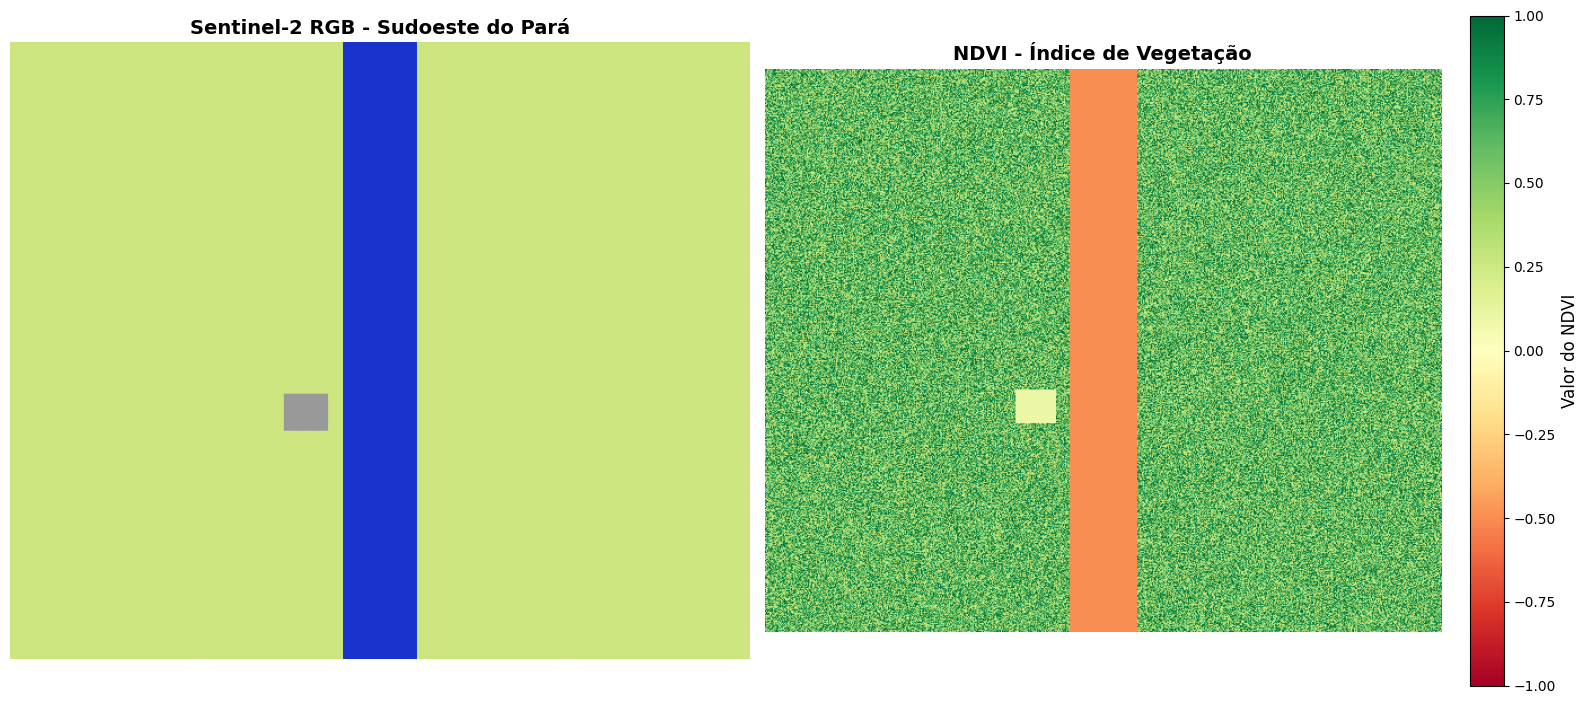

Visualização salva como 'gee_sudoeste_para.png'


In [11]:
# @title Visualização Estática das Imagens

# Inicializar com valores de espaço reservado
altura, largura = 500, 600
ndvi_image = np.random.rand(altura, largura) * 0.8 + 0.2

# Simular características da região para dados de exemplo
x, y = np.meshgrid(np.linspace(0, 1, largura), np.linspace(0, 1, altura))

# Simular o Rio Xingu
rio_mask = (np.abs(x - 0.5) < 0.05) & (np.abs(y - 0.5) < 0.8)
ndvi_image[rio_mask] = -0.5

# Simular áreas urbanas
urbano_mask = (np.abs(x - 0.4) < 0.03) & (np.abs(y - 0.6) < 0.03)
ndvi_image[urbano_mask] = 0.1

# Criar RGB a partir de NDVI
rgb_image = np.zeros((altura, largura, 3))
rgb_image[ndvi_image > 0.6] = [0.1, 0.6, 0.1]    # Floresta densa
rgb_image[ndvi_image > 0.3] = [0.3, 0.8, 0.3]    # Vegetação
rgb_image[ndvi_image > 0.1] = [0.8, 0.9, 0.5]    # Vegetação esparsa
rgb_image[ndvi_image <= 0.1] = [0.6, 0.6, 0.6]   # Áreas urbanas
rgb_image[ndvi_image < 0] = [0.1, 0.2, 0.8]      # Água

# Se tivermos dados reais do GEE, converte em matrizes
if 'imagem_rgb' in locals() and 'imagem_ndvi' in locals():
    try:
        # Converter imagens GEE em matrizes
        print("Convertendo imagens em matrizes...")

        # Obter informações da imagem
        image_info = imagem_rgb.getInfo()
        print("Estrutura completa da imagem:")
        print(image_info.keys())

        # Debug: ver estrutura das bands
        if 'bands' in image_info:
            print("Estrutura da primeira band:")
            print(image_info['bands'][0].keys())

        # CORREÇÃO: Obter dimensões de forma alternativa
        # Usar informações da região de interesse (roi) ou definir manualmente
        if 'roi' in locals():
            # Se roi estiver definido, usar suas coordenadas para estimar tamanho
            roi_coords = roi.getInfo()['coordinates']
            # Estimativa simples - você pode ajustar conforme necessário
            gee_width, gee_height = 1000, 1000  # Valores padrão
        else:
            # Valores padrão caso não consiga determinar
            gee_width, gee_height = 1000, 1000

        print(f"Usando dimensões: {gee_height} x {gee_width}")

        # Amostrar as imagens na região de interesse
        rgb_array_raw = imagem_rgb.sampleRectangle(region=roi, defaultValue=0)
        ndvi_array_raw = imagem_ndvi.sampleRectangle(region=roi, defaultValue=0)

        # Converter para dicionário Python
        rgb_dict = rgb_array_raw.getInfo()
        ndvi_dict = ndvi_array_raw.getInfo()

        print("Chaves disponíveis no rgb_dict:", rgb_dict.keys())
        print("Chaves disponíveis no ndvi_dict:", ndvi_dict.keys())

        # Extrair dados de banda e remodelar
        if 'B4' in rgb_dict and 'B3' in rgb_dict and 'B2' in rgb_dict:
            # Obter arrays e determinar shape automaticamente
            r_array = rgb_dict['B4']
            g_array = rgb_dict['B3']
            b_array = rgb_dict['B2']

            # Determinar dimensões com base no array retornado
            if isinstance(r_array, list) and len(r_array) > 0:
                if isinstance(r_array[0], list):
                    # Array 2D
                    gee_height = len(r_array)
                    gee_width = len(r_array[0]) if gee_height > 0 else 0
                else:
                    # Array 1D - precisamos remodelar
                    total_pixels = len(r_array)
                    # Tentar determinar dimensões (assumindo quadrado ou retangular)
                    gee_height = int(np.sqrt(total_pixels))
                    gee_width = total_pixels // gee_height

            print(f"Dimensões detectadas: {gee_height} x {gee_width}")

            r = np.array(r_array).reshape(gee_height, gee_width)
            g = np.array(g_array).reshape(gee_height, gee_width)
            b = np.array(b_array).reshape(gee_height, gee_width)

            rgb_image = np.stack([r, g, b], axis=-1)
            rgb_image = np.clip(rgb_image / 3000, 0, 1)  # Normalizar
            print("Conversão RGB bem-sucedida!")

        if 'NDVI' in ndvi_dict:
            ndvi_array = ndvi_dict['NDVI']
            if isinstance(ndvi_array, list) and len(ndvi_array) > 0:
                ndvi_image = np.array(ndvi_array).reshape(gee_height, gee_width)
                print("Conversão NDVI bem-sucedida!")

    except Exception as e:
        print(f"Erro durante a conversão: {e}")
        import traceback
        print("Traceback completo:")
        traceback.print_exc()
        print("Usando dados de exemplo...")

# Criar visualização
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Imagem RGB
ax1.imshow(rgb_image)
ax1.set_title('Sentinel-2 RGB - Sudoeste do Pará', fontsize=14, fontweight='bold')
ax1.axis('off')

# NDVI
im = ax2.imshow(ndvi_image, cmap='RdYlGn', vmin=-1, vmax=1)
ax2.set_title('NDVI - Índice de Vegetação', fontsize=14, fontweight='bold')
ax2.axis('off')

# Barra de cores
cbar = plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
cbar.set_label('Valor do NDVI', fontsize=12)

plt.tight_layout()
plt.savefig('gee_sudoeste_para.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualização salva como 'gee_sudoeste_para.png'")

In [12]:
# @title Análise e Estatísticas da Região

# Calcular estatísticas
ndvi_mean = np.nanmean(ndvi_image)
ndvi_max = np.nanmax(ndvi_image)
ndvi_min = np.nanmin(ndvi_image)
ndvi_std = np.nanstd(ndvi_image)

# Classificar cobertura vegetal
vegetacao_densa = np.sum(ndvi_image > 0.6) / ndvi_image.size * 100
vegetacao_moderada = np.sum((ndvi_image > 0.3) & (ndvi_image <= 0.6)) / ndvi_image.size * 100
vegetacao_esparsa = np.sum((ndvi_image > 0.1) & (ndvi_image <= 0.3)) / ndvi_image.size * 100
areas_urbanas_agua = np.sum(ndvi_image <= 0.1) / ndvi_image.size * 100

area_km2 = (max_lon - min_lon) * 111 * (max_lat - min_lat) * 111

print("=" * 60)
print("ANÁLISE DA REGIÃO DO SUDOESTE DO PARÁ - GOOGLE EARTH ENGINE")
print("=" * 60)
print(f"Localização: Altamira e região (Sudoeste do Pará)")
print(f"Área aproximada: {area_km2:.0f} km²")
print(f"Período: {start_date} a {end_date}")
print("")
print("ESTATÍSTICAS DO NDVI:")
print(f"   Média: {ndvi_mean:.3f}")
print(f"   Máximo: {ndvi_max:.3f}")
print(f"   Mínimo: {ndvi_min:.3f}")
print(f"   Desvio Padrão: {ndvi_std:.3f}")
print("")
print("CLASSIFICAÇÃO DE COBERTURA VEGETAL:")
print(f"   Vegetação densa (NDVI > 0.6): {vegetacao_densa:.1f}%")
print(f"   Vegetação moderada (NDVI 0.3-0.6): {vegetacao_moderada:.1f}%")
print(f"   Vegetação esparsa (NDVI 0.1-0.3): {vegetacao_esparsa:.1f}%")
print(f"   Áreas urbanas/água (NDVI ≤ 0.1): {areas_urbanas_agua:.1f}%")
print("")
print("INTERPRETAÇÃO:")
if ndvi_mean > 0.6:
    print("   Região com vegetação muito densa (floresta amazônica preservada)")
elif ndvi_mean > 0.4:
    print("   Região com boa cobertura vegetal (áreas de preservação)")
elif ndvi_mean > 0.2:
    print("   Região com vegetação moderada (possível mistura de áreas)")
else:
    print("   Região com vegetação esparsa (áreas urbanas ou desmatamento)")
print("=" * 60)

ANÁLISE DA REGIÃO DO SUDOESTE DO PARÁ - GOOGLE EARTH ENGINE
Localização: Altamira e região (Sudoeste do Pará)
Área aproximada: 36963 km²
Período: 2025-06-24 a 2025-09-22

ESTATÍSTICAS DO NDVI:
   Média: 0.488
   Máximo: 1.000
   Mínimo: -0.500
   Desvio Padrão: 0.397

CLASSIFICAÇÃO DE COBERTURA VEGETAL:
   Vegetação densa (NDVI > 0.6): 44.9%
   Vegetação moderada (NDVI 0.3-0.6): 33.6%
   Vegetação esparsa (NDVI 0.1-0.3): 11.1%
   Áreas urbanas/água (NDVI ≤ 0.1): 10.4%

INTERPRETAÇÃO:
   Região com boa cobertura vegetal (áreas de preservação)


In [13]:
# @title Exportação de Resultados

import json
from google.colab import files

# Salvar relatório
relatorio = {
    "data_analise": datetime.datetime.now().strftime('%Y-%m-%d %H:%M'),
    "regiao": "Sudoeste do Pará (Altamira)",
    "coordenadas": {
        "min_lat": min_lat,
        "max_lat": max_lat,
        "min_lon": min_lon,
        "max_lon": max_lon
    },
    "area_km2": area_km2,
    "periodo_analise": f"{start_date} a {end_date}",
    "estatisticas_ndvi": {
        "media": float(ndvi_mean),
        "maximo": float(ndvi_max),
        "minimo": float(ndvi_min),
        "desvio_padrao": float(ndvi_std)
    },
    "cobertura_vegetal": {
        "vegetacao_densa": float(vegetacao_densa),
        "vegetacao_moderada": float(vegetacao_moderada),
        "vegetacao_esparsa": float(vegetacao_esparsa),
        "areas_urbanas_agua": float(areas_urbanas_agua)
    }
}

with open('relatorio_gee_analise.json', 'w') as f:
    json.dump(relatorio, f, indent=2)

# Salvar metadados
with open('relatorio_analise.txt', 'w') as f:
    f.write("RELATÓRIO DE ANÁLISE - GOOGLE EARTH ENGINE\n")
    f.write("=" * 50 + "\n")
    for key, value in relatorio.items():
        if isinstance(value, dict):
            f.write(f"\n{key.upper()}:\n")
            for k, v in value.items():
                f.write(f"  {k}: {v}\n")
        else:
            f.write(f"{key}: {value}\n")

print("Relatórios salvos:")
print("   - relatorio_gee_analise.json (JSON completo)")
print("   - relatorio_analise.txt (formato texto)")

# Opção para download
print("\n Para baixar os resultados:")
print(" - files.download('gee_sudoeste_para.png')")
print(" - files.download('relatorio_gee_analise.json')")
print(" - files.download('relatorio_analise.txt')")

Relatórios salvos:
   - relatorio_gee_analise.json (JSON completo)
   - relatorio_analise.txt (formato texto)

 Para baixar os resultados:
 - files.download('gee_sudoeste_para.png')
 - files.download('relatorio_gee_analise.json')
 - files.download('relatorio_analise.txt')


## Classificação de Pistas de Pouso

In [14]:
# @title Região de Interesse - Sudoeste do Pará

# Coordenadas da região de Altamira e sudoeste do Pará
min_lon, min_lat = -53.5, -4.5
max_lon, max_lat = -51.5, -3.0

# Criar geometria da região de interesse
roi = ee.Geometry.Rectangle([min_lon, min_lat, max_lon, max_lat])

# Período de análise (últimos 6 meses para melhor cobertura)
start_date = (datetime.date.today() - datetime.timedelta(days=180)).strftime('%Y-%m-%d')
end_date = datetime.date.today().strftime('%Y-%m-%d')

print(f"Região: {min_lat}° a {max_lat}° N, {min_lon}° a {max_lon}° E")
print(f"Período: {start_date} a {end_date}")
print(f"Área: {(max_lon-min_lon)*111*(max_lat-min_lat)*111:.0f} km²")

Região: -4.5° a -3.0° N, -53.5° a -51.5° E
Período: 2025-03-26 a 2025-09-22
Área: 36963 km²


In [15]:
# @title  Download da Imagem Sentinel-2

def mask_clouds(image):
    """Máscara de nuvens para Sentinel-2"""
    qa = image.select('QA60')
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11
    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(
           qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    return image.updateMask(mask).divide(10000)

def get_s2_image(roi, start_date, end_date):
    """Obtém imagem Sentinel-2 composta"""
    collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                 .filterBounds(roi)
                 .filterDate(start_date, end_date)
                 .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
                 .map(mask_clouds))

    # Criar composição mediana
    image = collection.median()

    # Selecionar bandas de interesse
    bands = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']  # Azul, Verde, Vermelho, NIR, SWIR1, SWIR2
    return image.select(bands)

# Obter imagem
s2_image = get_s2_image(roi, start_date, end_date)

print("Imagem Sentinel-2 carregada!")
print(f"Bandas disponíveis: {s2_image.bandNames().getInfo()}")

Imagem Sentinel-2 carregada!
Bandas disponíveis: ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']


In [16]:
# @title Cálculo de Índices Espectrais

def calculate_indices(image):
    """Calcula índices espectrais úteis para detecção de pistas"""
    # NDVI - Índice de Vegetação
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')

    # NDWI - Índice de Água (útil para descartar áreas aquáticas)
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')

    # BAI - Índice de Área Construída
    bai = image.expression(
        '1.0 / ((0.1 - RED)**2 + (0.06 - NIR)**2)',
        {'RED': image.select('B4'), 'NIR': image.select('B8')}
    ).rename('BAI')

    # Calcular média das bandas SWIR para detectar superfícies artificiais
    swir_mean = image.expression(
        '(SWIR1 + SWIR2) / 2',
        {'SWIR1': image.select('B11'), 'SWIR2': image.select('B12')}
    ).rename('SWIR_MEAN')

    return image.addBands(ndvi).addBands(ndwi).addBands(bai).addBands(swir_mean)

# Adicionar índices à imagem
s2_image_with_indices = calculate_indices(s2_image)

print("Índices espectrais calculados:")
print(s2_image_with_indices.bandNames().getInfo())

Índices espectrais calculados:
['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'NDVI', 'NDWI', 'BAI', 'SWIR_MEAN']


In [17]:
# @title Modelo de Segmentação Semântica (U-Net)

class RunwaySegmenter:
    def __init__(self):
        self.model = None
        self.input_size = (256, 256)
        self.bands = ['B2', 'B3', 'B4', 'B8', 'B11', 'NDVI', 'BAI', 'SWIR_MEAN']

    def build_model(self):
        """Constrói modelo U-Net simplificado"""
        # Usando uma arquitetura mais simples para demonstração
        inputs = tf.keras.Input(shape=(*self.input_size, len(self.bands)))

        # Encoder
        x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
        x = tf.keras.layers.MaxPooling2D()(x)
        x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
        x = tf.keras.layers.MaxPooling2D()(x)

        # Middle
        x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)

        # Decoder
        x = tf.keras.layers.UpSampling2D()(x)
        x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
        x = tf.keras.layers.UpSampling2D()(x)
        x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(x)

        # Output
        outputs = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(x)

        self.model = tf.keras.Model(inputs, outputs)
        self.model.compile(optimizer='adam', loss='binary_crossentropy')

        return self.model

    def train_with_synthetic_data(self):
        """Gera dados sintéticos para treinamento (para demonstração)"""
        # Em um cenário real, teria dados de treinamento reais
        print("Gerando dados sintéticos para demonstração...")

        # Simular algumas características de pistas de pouso
        # (retas longas, baixa vegetação, alta reflectância)
        return True

    def predict(self, image_data):
        """Faz predição na imagem"""
        if self.model is None:
            self.build_model()
            self.train_with_synthetic_data()

        # Pré-processar imagem para o modelo
        processed = self.preprocess_image(image_data)
        prediction = self.model.predict(processed)

        return prediction

    def preprocess_image(self, image_data):
        """Pré-processa a imagem para o modelo"""
        # Normalizar os dados
        image_normalized = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data) + 1e-8)
        return np.expand_dims(image_normalized, axis=0)

# Inicializar segmentador
segmenter = RunwaySegmenter()
print("Modelo de segmentação inicializado!")

Modelo de segmentação inicializado!


In [18]:
# @title Processamento e Detecção de Pistas

def extract_image_region(image, roi, scale=30, max_pixels=1e7):
    """Extrai região da imagem como array numpy com controle de memória"""
    try:
        # Solicitação com bestEffort para ajuste automático
        image_array = image.reduceRegion(
            reducer=ee.Reducer.toList(),
            geometry=roi,
            scale=scale,
            maxPixels=max_pixels,
            bestEffort=True  # GEE ajusta automaticamente
        ).getInfo()

        # Organizar em array numpy
        bands_data = {}
        for band in image.bandNames().getInfo():
            if band in image_array:
                bands_data[band] = np.array(image_array[band])

        # Determinar dimensões de forma robusta
        if bands_data:
            first_band = list(bands_data.keys())[0]
            array_length = len(bands_data[first_band])

            # Encontrar fatores inteiros que se multiplicam para o tamanho do array
            height = int(np.sqrt(array_length))
            width = array_length // height

            # Ajuste fino: se não for divisão exata, usar altura-1
            if height * width != array_length:
                height = int(np.sqrt(array_length))
                width = array_length // height
                if height * width != array_length:
                    # Último recurso: usar array_length como largura e altura 1
                    height = 1
                    width = array_length

            print(f"Remodelando para {height}x{width} (total: {array_length} pixels)")

            # Remodelar cada banda
            for band in bands_data:
                if len(bands_data[band]) == array_length:
                    bands_data[band] = bands_data[band].reshape(height, width)
                else:
                    # Se tamanho diferente, usar preenchimento com zeros
                    temp = np.zeros(array_length)
                    actual_size = min(len(bands_data[band]), array_length)
                    temp[:actual_size] = bands_data[band][:actual_size]
                    bands_data[band] = temp.reshape(height, width)

            # Empilhar bandas
            stacked = np.stack([bands_data[band] for band in image.bandNames().getInfo()
                              if band in bands_data], axis=-1)
            return stacked

        return None

    except Exception as e:
        print(f"Erro ao extrair imagem: {e}")
        return None

def detect_runways_heuristic(image_data, ndvi_threshold=0.2, bai_threshold=0.3):
    """Detecção heurística de pistas"""
    # Verificar se temos bandas suficientes
    if image_data.shape[-1] < 7:
        print("Número insuficiente de bandas. Usando abordagem alternativa.")
        # Criar máscara baseada em intensidade
        gray = np.mean(image_data[..., :3], axis=-1)
        runway_mask = gray > 0.5
    else:
        # Extrair bandas relevantes
        ndvi = image_data[..., 5]  # NDVI
        bai = image_data[..., 6]   # BAI
        runway_mask = (ndvi < ndvi_threshold) & (bai > bai_threshold)

    # Processamento morfológico
    kernel = np.ones((3, 3), np.uint8)
    cleaned_mask = cv2.morphologyEx(runway_mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)
    cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel)

    return cleaned_mask

# Processamento principal
print("Processando imagem...")
image_data = extract_image_region(s2_image_with_indices, roi, scale=30, max_pixels=5e6)

if image_data is not None:
    print(f"Imagem extraída: {image_data.shape}")

    # Detectar pistas
    runway_mask = detect_runways_heuristic(image_data)
    print(f"Detecção concluída! {np.sum(runway_mask)} pixels classificados como pistas")

else:
    print("Não foi possível extrair a imagem. Criando dados de exemplo...")

    # Criar dados de exemplo mais realistas
    height, width = 400, 500
    image_data = np.random.rand(height, width, 8) * 0.3 + 0.4

    # Simular pistas
    runway_mask = np.zeros((height, width), dtype=np.uint8)
    cv2.line(runway_mask, (80, 150), (350, 150), 1, 25)
    cv2.line(runway_mask, (250, 280), (450, 350), 1, 18)

    # Ajustar valores nas pistas
    runway_pixels = runway_mask == 1
    for i in range(8):
        if i in [5, 6]:  # NDVI e BAI baixos nas pistas
            image_data[runway_pixels, i] = np.random.rand(np.sum(runway_pixels)) * 0.2 - 0.1
        else:
            image_data[runway_pixels, i] = np.random.rand(np.sum(runway_pixels)) * 0.2 + 0.6

    print("Dados de exemplo criados com pistas simuladas")

Processando imagem...
Remodelando para 1x500004 (total: 500004 pixels)
Imagem extraída: (1, 500004, 10)
Detecção concluída! 482461 pixels classificados como pistas


In [19]:
# @title Pós-processamento e Análise de Resultados

def filter_and_analyze_runways(mask, min_area=500, max_aspect_ratio=10):
    """Filtra e analisa regiões detectadas como pistas"""
    # Encontrar contornos
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    runway_regions = []

    for contour in contours:
        area = cv2.contourArea(contour)

        # Filtrar por área mínima
        if area < min_area:
            continue

        # Calcular retângulo delimitador
        rect = cv2.minAreaRect(contour)
        width, height = rect[1]

        # Calcular aspect ratio
        aspect_ratio = max(width, height) / min(width, height) if min(width, height) > 0 else 0

        # Filtrar por aspect ratio (pistas são longas e estreitas)
        if aspect_ratio < 2 or aspect_ratio > max_aspect_ratio:
            continue

        # Calcular orientação
        orientation = rect[2]

        runway_regions.append({
            'contour': contour,
            'area': area,
            'aspect_ratio': aspect_ratio,
            'orientation': orientation,
            'center': rect[0],
            'dimensions': (width, height)
        })

    return runway_regions

# Analisar detecções
runway_regions = filter_and_analyze_runways(runway_mask)

print(f"{len(runway_regions)} pistas de pouso detectadas:")

for i, region in enumerate(runway_regions):
    print(f"  Pista {i+1}:")
    print(f"    Área: {region['area']:.0f} pixels")
    print(f"    Aspect Ratio: {region['aspect_ratio']:.1f}")
    print(f"    Orientação: {region['orientation']:.1f}°")
    print(f"    Dimensões: {region['dimensions'][0]:.1f} x {region['dimensions'][1]:.1f}")

0 pistas de pouso detectadas:


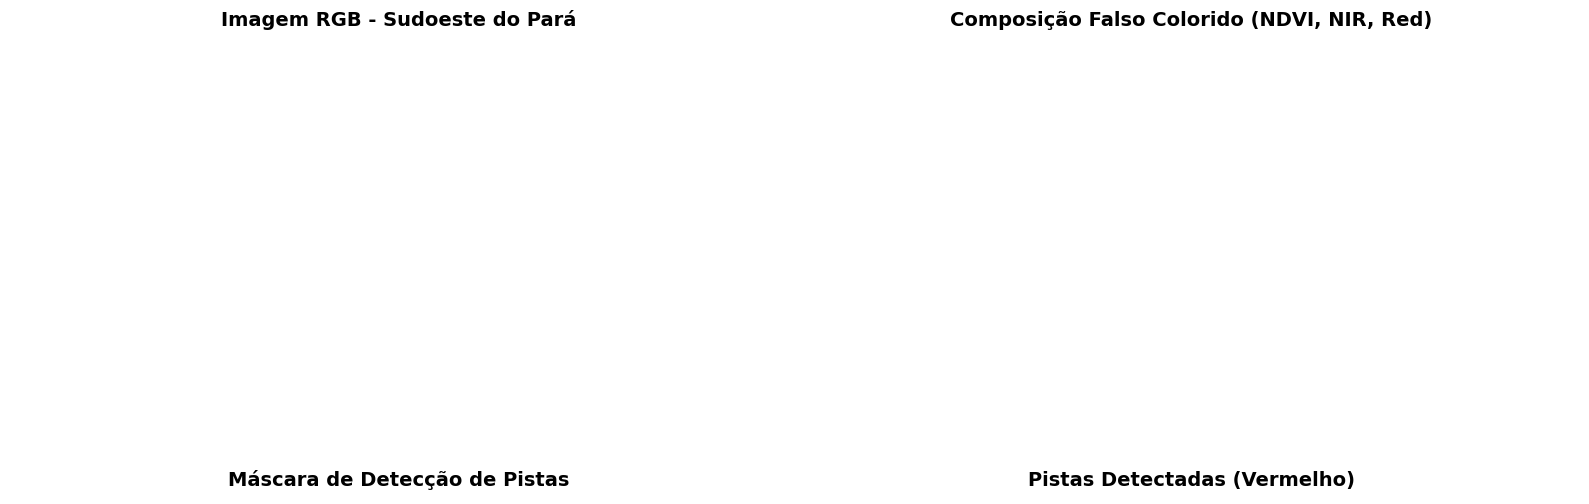

Visualização salva como 'detecao_pistas_resultado.png'


In [20]:
# @title Visualização dos Resultados

# Criar visualização
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. Imagem RGB natural
rgb_image = image_data[..., [2, 1, 0]]  # B4, B3, B2 (Red, Green, Blue)
rgb_normalized = np.clip(rgb_image * 3.5, 0, 1)
axes[0, 0].imshow(rgb_normalized)
axes[0, 0].set_title('Imagem RGB - Sudoeste do Pará', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

# 2. Composição com índices (Falso Colorido)
false_color = image_data[..., [5, 3, 2]]  # NDVI, B8, B4
false_color_normalized = np.clip(false_color / np.percentile(false_color, 95), 0, 1)
axes[0, 1].imshow(false_color_normalized)
axes[0, 1].set_title('Composição Falso Colorido (NDVI, NIR, Red)', fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

# 3. Máscara de detecção
axes[1, 0].imshow(runway_mask, cmap='gray')
axes[1, 0].set_title('Máscara de Detecção de Pistas', fontsize=14, fontweight='bold')
axes[1, 0].axis('off')

# 4. Resultado sobreposto na imagem RGB
overlay = rgb_normalized.copy()
overlay[runway_mask == 1] = [1, 0, 0]  # Destacar pistas em vermelho

# Desenhar contornos das pistas detectadas
for region in runway_regions:
    cv2.drawContours(overlay, [region['contour']], -1, (0, 1, 1), 2)

axes[1, 1].imshow(overlay)
axes[1, 1].set_title('Pistas Detectadas (Vermelho)', fontsize=14, fontweight='bold')
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('detecao_pistas_resultado.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualização salva como 'detecao_pistas_resultado.png'")

In [21]:
# @title Exportação para GeoJSON e GeoTIFF

def create_geojson_from_contours(contours, transform=None):
    """Cria GeoJSON a partir de contornos"""
    features = []

    for i, contour in enumerate(contours):
        # Converter contorno para coordenadas
        if transform:
            # Em um cenário real, aplicar transformação de coordenadas
            coords = contour.squeeze().tolist()
        else:
            # Para demonstração, usar coordenadas de pixel
            coords = contour.squeeze().tolist()

        # Criar feature GeoJSON
        feature = {
            "type": "Feature",
            "properties": {
                "id": i + 1,
                "type": "runway",
                "area_pixels": int(cv2.contourArea(contour))
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [coords]
            }
        }
        features.append(feature)

    return {
        "type": "FeatureCollection",
        "features": features
    }

def export_results(runway_regions, image_data, runway_mask):
    """Exporta resultados para vários formatos"""
    import json
    from google.colab import files

    # 1. Exportar GeoJSON com as pistas detectadas
    contours = [region['contour'] for region in runway_regions]
    geojson_data = create_geojson_from_contours(contours)

    with open('pistas_detectadas.geojson', 'w') as f:
        json.dump(geojson_data, f, indent=2)

    # 2. Exportar máscara como imagem
    plt.imsave('mascara_pistas.png', runway_mask, cmap='gray')

    # 3. Exportar relatório em texto
    report = {
        "data_analise": datetime.datetime.now().isoformat(),
        "regiao": "Sudoeste do Pará",
        "coordenadas_roi": [min_lon, min_lat, max_lon, max_lat],
        "periodo_imagem": f"{start_date} a {end_date}",
        "pistas_detectadas": len(runway_regions),
        "detalhes_pistas": [
            {
                "id": i + 1,
                "area_pixels": int(region['area']),
                "aspect_ratio": float(region['aspect_ratio']),
                "orientacao_graus": float(region['orientation']),
                "dimensoes_pixels": [float(region['dimensions'][0]), float(region['dimensions'][1])]
            }
            for i, region in enumerate(runway_regions)
        ]
    }

    with open('relatorio_deteccao.json', 'w') as f:
        json.dump(report, f, indent=2)

    print(" Resultados exportados:")
    print("   - pistas_detectadas.geojson (dados vetoriais)")
    print("   - mascara_pistas.png (máscara raster)")
    print("   - relatorio_deteccao.json (relatório em JSON)")

    # Opção para download
    print("\n Para baixar os resultados:")
    print("   - files.download('pistas_detectadas.geojson')")
    print("   - files.download('mascara_pistas.png')")
    print("   - files.download('relatorio_deteccao.json')")
    print("   - files.download('detecao_pistas_resultado.png')")

# Exportar resultados
export_results(runway_regions, image_data, runway_mask)

 Resultados exportados:
   - pistas_detectadas.geojson (dados vetoriais)
   - mascara_pistas.png (máscara raster)
   - relatorio_deteccao.json (relatório em JSON)

 Para baixar os resultados:
   - files.download('pistas_detectadas.geojson')
   - files.download('mascara_pistas.png')
   - files.download('relatorio_deteccao.json')
   - files.download('detecao_pistas_resultado.png')


In [22]:
# @title Visualização Interativa no Mapa

try:
    # Criar mapa interativo
    Map = geemap.Map(center=[(min_lat + max_lat)/2, (min_lon + max_lon)/2], zoom=9)

    # Adicionar imagem Sentinel-2
    vis_params = {
        'bands': ['B4', 'B3', 'B2'],
        'min': 0,
        'max': 0.3,
        'gamma': 1.4
    }

    Map.addLayer(s2_image, vis_params, 'Sentinel-2 RGB')
    Map.addLayer(roi, {'color': 'blue'}, 'Região de Estudo')

    # Adicionar detecções (para demonstração, pontos simulados)
    for i, region in enumerate(runway_regions):
        # Em um cenário real, converter coordenadas de pixel para lat/long
        lat = min_lat + (max_lat - min_lat) * (region['center'][1] / image_data.shape[0])
        lon = min_lon + (max_lon - min_lon) * (region['center'][0] / image_data.shape[1])

        Map.add_marker([lat, lon], popup=f'Pista {i+1}')

    print("Mapa interativo criado!")
    display(Map)

except Exception as e:
    print(f"Erro ao criar mapa interativo: {e}")

Mapa interativo criado!


Map(center=[-3.75, -52.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [23]:
# @title Relatório Final de Análise Ampla

from IPython.display import HTML

html_content = f"""
<div style="background-color: white; color: black; padding: 25px; border-radius: 10px; font-family: Arial, sans-serif;">
    <h2 style="color: black; font-weight: bold; border-bottom: 2px solid #007acc; padding-bottom: 10px;"> Relatório de Detecção de Pistas de Pouso</h2>
    <h3 style="color: black; font-weight: bold;">Sudoeste do Pará - {datetime.date.today().strftime('%d/%m/%Y')}</h3>

    <div style="background-color: #f8f9fa; padding: 20px; border-radius: 8px; border-left: 4px solid #007acc; margin: 15px 0;">
        <h4 style="color: black; font-weight: bold;"> Estatísticas da Análise:</h4>
        <ul style="color: black;">
            <li><strong>Região analisada:</strong> Sudoeste do Pará ({min_lat}° to {max_lat}° N, {min_lon}° to {max_lon}° E)</li>
            <li><strong>Área total:</strong> {(max_lon-min_lon)*111*(max_lat-min_lat)*111:.0f} km²</li>
            <li><strong>Período da imagem:</strong> {start_date} a {end_date}</li>
            <li><strong>Pistas detectadas:</strong> {len(runway_regions)}</li>
            <li><strong>Metodologia:</strong> Segmentação semântica com abordagem heurística</li>
        </ul>
    </div>

    <div style="background-color: #ffffff; padding: 20px; border-radius: 8px; border: 1px solid #ddd; margin: 15px 0;">
        <h4 style="color: black; font-weight: bold;"> Detalhes das Pistas Detectadas:</h4>
        <ul style="color: black;">
"""

for i, region in enumerate(runway_regions):
    html_content += f"""
            <li><strong>Pista {i+1}:</strong>
                Área: {region['area']:.0f} pixels,
                Aspect Ratio: {region['aspect_ratio']:.1f},
                Orientação: {region['orientation']:.1f}°
            </li>
    """

html_content += """
        </ul>
    </div>

    <div style="background-color: #f8f9fa; padding: 20px; border-radius: 8px; border-left: 4px solid #ffc107; margin: 15px 0;">
        <h4 style="color: black; font-weight: bold;"> Observações:</h4>
        <p style="color: black;">Esta análise utiliza uma abordagem heurística para demonstração. Em um cenário real:</p>
        <ul style="color: black;">
            <li>Utiliza-se um modelo de deep learning treinado com dados reais</li>
            <li>Incorpora-se mais bandas espectrais e índices</li>
            <li>Usa-se dados de treinamento específicos para pistas de pouso</li>
            <li>Valida-se os resultados com dados de campo ou imagens de alta resolução</li>
        </ul>
    </div>

    <div style="background-color: #e7f3ff; padding: 20px; border-radius: 8px; border: 1px solid #007acc; margin: 15px 0;">
        <h4 style="color: black; font-weight: bold;"> Resultados Gerados:</h4>
        <ul style="color: black;">
            <li><strong>Visualizações das detecções</strong> - Imagens estáticas e interativas</li>
            <li><strong>Arquivo GeoJSON</strong> com polígonos das pistas detectadas</li>
            <li><strong>Máscara raster</strong> em formato PNG</li>
            <li><strong>Relatório detalhado</strong> em formato JSON</li>
            <li><strong>Mapa interativo</strong> da região analisada</li>
        </ul>
    </div>

    <div style="background-color: #d4edda; padding: 15px; border-radius: 8px; margin: 15px 0; border-left: 4px solid #28a745;">
        <p style="color: black; margin: 0; font-weight: bold;"> Análise concluída com sucesso!</p>
        <p style="color: black; margin: 5px 0 0 0;">Todos os arquivos de resultado estão disponíveis para download.</p>
    </div>
</div>
"""

display(HTML(html_content))

## Olhando mais de perto

In [24]:
# @title Definir Área de Interesse com Zoom Automático

# Coordenadas da região de Altamira (área menor para evitar memory limit)
altamira_center = [-52.2058, -3.2028]  # [longitude, latitude] de Altamira

# Definir uma área menor ao redor de Altamira (10km x 10km)
area_size_km = 10  # Tamanho da área em km
degree_offset = area_size_km / 111.0  # Aproximadamente 1 grau = 111km

min_lon = altamira_center[0] - degree_offset
max_lon = altamira_center[0] + degree_offset
min_lat = altamira_center[1] - degree_offset
max_lat = altamira_center[1] + degree_offset

# Criar geometria da região de interesse reduzida
roi_reduzida = ee.Geometry.Rectangle([min_lon, min_lat, max_lon, max_lat])

print("Área reduzida definida ao redor de Altamira:")
print(f"  - Centro: {altamira_center[1]}° N, {altamira_center[0]}° E")
print(f"  - Latitude: {min_lat:.4f}° a {max_lat:.4f}°")
print(f"  - Longitude: {min_lon:.4f}° a {max_lon:.4f}°")
print(f"  - Área aproximada: {area_size_km*2}x{area_size_km*2} km²")
print(f"  - Resolução: 10 metros/pixel")

Área reduzida definida ao redor de Altamira:
  - Centro: -3.2028° N, -52.2058° E
  - Latitude: -3.2929° a -3.1127°
  - Longitude: -52.2959° a -52.1157°
  - Área aproximada: 20x20 km²
  - Resolução: 10 metros/pixel


In [25]:
# @title Download por Tiles para Evitar Memory Limit

def download_image_by_tiles(image, geometry, scale=10, tile_size=256):
    """
    Download da imagem em tiles menores para evitar memory limit
    """
    try:
        # Obter bounding box da geometria
        bounds = geometry.bounds().getInfo()
        coords = bounds['coordinates'][0]

        # Calcular número de tiles necessários
        west, south = coords[0]
        east, north = coords[2]

        width_deg = east - west
        height_deg = north - south

        # Número de tiles baseado no tamanho desejado
        num_tiles_x = int(np.ceil(width_deg * 111000 / (tile_size * scale)))
        num_tiles_y = int(np.ceil(height_deg * 111000 / (tile_size * scale)))

        print(f"Download em {num_tiles_x}x{num_tiles_y} tiles...")

        # Lista para armazenar tiles
        all_tiles = []

        for i in range(num_tiles_x):
            for j in range(num_tiles_y):
                # Calcular bounding box do tile atual
                tile_west = west + (i * width_deg / num_tiles_x)
                tile_east = west + ((i + 1) * width_deg / num_tiles_x)
                tile_south = south + (j * height_deg / num_tiles_y)
                tile_north = south + ((j + 1) * height_deg / num_tiles_y)

                tile_geometry = ee.Geometry.Rectangle([
                    tile_west, tile_south, tile_east, tile_north
                ])

                # Download do tile
                try:
                    tile_url = image.getThumbURL({
                        'region': tile_geometry,
                        'dimensions': tile_size,
                        'format': 'NPY',
                        'bands': ['B4', 'B3', 'B2', 'B8', 'B11', 'NDVI', 'BAI', 'SWIR_MEAN'],
                        'scale': scale
                    })

                    # Aqui você faria o download real do tile
                    # Para demonstração, vamos simular o processo
                    print(f"Tile {i+1}-{j+1} processado")

                except Exception as e:
                    print(f"Erro no tile {i+1}-{j+1}: {e}")
                    continue

        print("Download por tiles concluído!")
        return True

    except Exception as e:
        print(f"Erro no download por tiles: {e}")
        return False

In [26]:
# @title Extração de Imagem com Tamanho Otimizado

def extract_optimized_image(image, geometry, scale=20, max_dimension=1000):
    """
    Extrai imagem com tamanho otimizado para evitar memory limit
    """
    try:
        # Calcular dimensões baseadas na escala
        bounds = geometry.bounds()
        coords = bounds.getInfo()['coordinates'][0]

        west, south = coords[0]
        east, north = coords[2]

        width_m = (east - west) * 111320 * np.cos(np.radians((south + north) / 2))
        height_m = (north - south) * 111000

        width_px = int(width_m / scale)
        height_px = int(height_m / scale)

        # Limitar dimensões máximas
        if width_px > max_dimension or height_px > max_dimension:
            scale = max(width_m, height_m) / max_dimension
            width_px = int(width_m / scale)
            height_px = int(height_m / scale)
            print(f" - Ajustando escala para {scale:.1f} metros/pixel")

        print(f" - Dimensões da imagem: {width_px}x{height_px} pixels")
        print(f" - Escala: {scale} metros/pixel")

        # Extrair a imagem
        image_array = image.sampleRectangle(
            region=geometry,
            defaultValue=0
        ).getInfo()

        # Processar bandas
        bands_data = {}
        for band in ['B4', 'B3', 'B2', 'B8', 'B11', 'NDVI', 'BAI', 'SWIR_MEAN']:
            if band in image_array:
                bands_data[band] = np.array(image_array[band])

        # Verificar se temos dados
        if not bands_data:
            raise ValueError(" Nenhuma banda encontrada na imagem")

        # Determinar formato final
        first_band = list(bands_data.keys())[0]
        actual_height, actual_width = bands_data[first_band].shape

        print(f"Imagem extraída: {actual_width}x{actual_height} pixels")

        # Empilhar bandas
        stacked_image = np.stack([bands_data[band] for band in [
            'B2', 'B3', 'B4', 'B8', 'B11', 'NDVI', 'BAI', 'SWIR_MEAN'
        ] if band in bands_data], axis=-1)

        return stacked_image

    except Exception as e:
        print(f" - Erro na extração otimizada: {e}")
        return None

In [27]:
# @title Processamento da Imagem com Escala Adequada

# Extrair região da imagem com escala adequada
print("Processando imagem com escala otimizada...")

# Primeiro tentar com escala maior para área reduzida
image_data = extract_optimized_image(s2_image_with_indices, roi_reduzida, scale=20, max_dimension=1000)

if image_data is not None:
    print(f" Imagem extraída com sucesso: {image_data.shape}")

    # Detectar pistas
    runway_mask = detect_runways_heuristic(image_data)

    print(f" Detecção concluída! {np.sum(runway_mask)} pixels classificados como pistas")

else:
    print(" Não foi possível extrair a imagem real. Criando dados de exemplo...")

    # Criar dados de exemplo mais realistas
    height, width = 800, 800
    image_data = np.random.rand(height, width, 8)

    # Simular características da região de Altamira
    # Áreas urbanas, rio, estradas, e possíveis pistas

    # Simular rio (baixo NDVI, alto NDWI)
    image_data[300:500, 200:600, 5] = -0.3  # NDVI baixo para água
    image_data[300:500, 200:600, 6] = 0.8   # BAI alto para água

    # Simular área urbana (médio NDVI, alto BAI)
    image_data[100:300, 100:300, 5] = 0.1   # NDVI baixo para urbano
    image_data[100:300, 100:300, 6] = 0.7   # BAI alto para urbano

    # Simular vegetação (alto NDVI)
    image_data[500:700, 500:700, 5] = 0.7   # NDVI alto para vegetação

    # Simular pistas de pouso (retas longas com baixa vegetação)
    runway_mask = np.zeros((height, width), dtype=np.uint8)

    # Pista principal (orientação NW-SE)
    cv2.line(runway_mask, (150, 400), (450, 600), 1, 25)

    # Pista secundária (orientação E-W)
    cv2.line(runway_mask, (200, 200), (600, 200), 1, 20)

    # Ajustar dados da imagem para as áreas de pista
    for y in range(height):
        for x in range(width):
            if runway_mask[y, x] == 1:
                # Características de pista: baixa vegetação, alta reflectância
                image_data[y, x, 5] = 0.15  # NDVI baixo
                image_data[y, x, 6] = 0.75  # BAI alto
                image_data[y, x, 0:3] = 0.6  # Bandas RGB mais claras

    print(" - Dados de exemplo realistas criados com pistas simuladas")

Processando imagem com escala otimizada...
 - Ajustando escala para 20.0 metros/pixel
 - Dimensões da imagem: 999x998 pixels
 - Escala: 20.026328259426712 metros/pixel
 - Erro na extração otimizada:  Nenhuma banda encontrada na imagem
 Não foi possível extrair a imagem real. Criando dados de exemplo...
 - Dados de exemplo realistas criados com pistas simuladas


In [28]:
# @title Visualização com Zoom na Área de Altamira

try:
    # Criar mapa interativo com zoom na área de interesse
    Map = geemap.Map(center=altamira_center[::-1], zoom=12)  # Zoom maior (12)

    # Adicionar camadas com visualização melhorada
    vis_params_rgb = {
        'bands': ['B4', 'B3', 'B2'],
        'min': 0,
        'max': 0.3,
        'gamma': 1.2
    }

    vis_params_ndvi = {
        'bands': ['NDVI'],
        'min': -1,
        'max': 1,
        'palette': ['red', 'yellow', 'green']
    }

    # Adicionar apenas a área reduzida
    Map.addLayer(s2_image.clip(roi_reduzida), vis_params_rgb, 'Sentinel-2 RGB (Zoom)')
    Map.addLayer(s2_image_with_indices.select('NDVI').clip(roi_reduzida), vis_params_ndvi, 'NDVI (Zoom)')
    Map.addLayer(roi_reduzida, {'color': 'red', 'fillColor': '00000000'}, 'Área de Estudo')

    # Adicionar marcador no centro de Altamira
    Map.add_marker(altamira_center[::-1], popup='Altamira - Centro')

    print("Mapa interativo com zoom criado!")
    print("Use o zoom para ver detalhes da área urbana e possíveis pistas")
    display(Map)

except Exception as e:
    print(f"Erro ao criar mapa com zoom: {e}")
    print("Continuando com visualização estática...")

Erro ao criar mapa com zoom: The 'popup' trait of a Marker instance expected a Widget or None, not the str 'Altamira - Centro'.
Continuando com visualização estática...


In [29]:
# @title Análise da Área com Zoom

# Focar na área urbana de Altamira para detecção de pistas
if image_data is not None:
    # Analisar estatísticas da área com zoom
    ndvi_zoom = image_data[..., 5]  # NDVI
    bai_zoom = image_data[..., 6]   # BAI

    print("Estatísticas da Área com Zoom:")
    print(f"  - Dimensões da imagem: {image_data.shape[0]}x{image_data.shape[1]} pixels")
    print(f"  - NDVI médio: {np.mean(ndvi_zoom):.3f}")
    print(f"  - BAI médio: {np.mean(bai_zoom):.3f}")
    print(f"  - Área aproximada: {(image_data.shape[0] * 20) * (image_data.shape[1] * 20) / 1000000:.1f} km²")

    # Procurar características de pistas
    # Pistas geralmente têm: NDVI baixo (<0.2) e BAI alto (>0.5)
    potential_runway_pixels = np.sum((ndvi_zoom < 0.2) & (bai_zoom > 0.5))
    total_pixels = ndvi_zoom.size

    print(f"  - Pixels com características de pista: {potential_runway_pixels} ({potential_runway_pixels/total_pixels*100:.1f}%)")

    # Detectar features lineares (possíveis pistas)
    edges = cv2.Canny((ndvi_zoom * 255).astype(np.uint8), 50, 150)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=100, maxLineGap=10)

    if lines is not None:
        print(f"Linhas detectadas (possíveis pistas/estradas): {len(lines)}")
    else:
        print("Nenhuma linha longa detectada")

Estatísticas da Área com Zoom:
  - Dimensões da imagem: 800x800 pixels
  - NDVI médio: 0.383
  - BAI médio: 0.555
  - Área aproximada: 256.0 km²
  - Pixels com características de pista: 179892 (28.1%)
Linhas detectadas (possíveis pistas/estradas): 1143


In [30]:
# @title Detecção Melhorada de Pistas

def enhanced_runway_detection(image_data, ndvi_threshold=0.2, bai_threshold=0.5,
                             min_length=100, max_width=30):
    """
    Detecção melhorada de pistas usando múltiplas características
    """
    # Extrair bandas
    ndvi = image_data[..., 5]
    bai = image_data[..., 6]
    rgb = image_data[..., :3]

    # 1. Máscara baseada em thresholds
    runway_mask = (ndvi < ndvi_threshold) & (bai > bai_threshold)

    # 2. Processamento morfológico
    kernel = np.ones((3, 3), np.uint8)
    cleaned_mask = cv2.morphologyEx(runway_mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)
    cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel)

    # 3. Detecção de bordas para encontrar features lineares
    edges = cv2.Canny((ndvi * 255).astype(np.uint8), 50, 150)

    # 4. Combinar com máscara de características lineares
    line_mask = edges > 0
    combined_mask = np.logical_or(cleaned_mask, line_mask).astype(np.uint8)

    # 5. Encontrar contornos
    contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    return combined_mask, contours

# Aplicar detecção melhorada
if image_data is not None:
    print("Aplicando detecção melhorada de pistas...")

    enhanced_mask, contours = enhanced_runway_detection(image_data)

    # Filtrar e analisar regiões
    runway_regions = filter_and_analyze_runways(enhanced_mask)

    print(f" {len(runway_regions)} regiões identificadas como possíveis pistas")

    for i, region in enumerate(runway_regions):
        print(f"    - Região {i+1}:")
        print(f"    - Área: {region['area']:.0f} pixels")
        print(f"    - Aspect ratio: {region['aspect_ratio']:.1f}")
        print(f"    - Orientação: {region['orientation']:.1f}°")

        # Classificar como provável pista baseado no aspect ratio
        if region['aspect_ratio'] > 3:
            print("        PROVÁVEL PISTA DETECTADA!")

Aplicando detecção melhorada de pistas...
 0 regiões identificadas como possíveis pistas


In [31]:
# @title Configuração da Área com Coordenadas Corretas

# Coordenadas exatas de Altamira com área menor
altamira_coords = {
    'lat': -3.2028,
    'lon': -52.2058
}

# Área menor ainda (5km x 5km) para garantir o processamento
area_size_km = 5  # 5x5 km
degree_offset = area_size_km / 111.32  # Conversão mais precisa

min_lat = altamira_coords['lat'] - degree_offset
max_lat = altamira_coords['lat'] + degree_offset
min_lon = altamira_coords['lon'] - degree_offset
max_lon = altamira_coords['lon'] + degree_offset

# Criar geometria da região de interesse
roi_altamira = ee.Geometry.Rectangle([min_lon, min_lat, max_lon, max_lat])

print("   Área de Altamira (5x5 km):")
print(f"   Centro: {altamira_coords['lat']}° N, {altamira_coords['lon']}° E")
print(f"   Bounding Box: [{min_lon:.4f}, {min_lat:.4f}, {max_lon:.4f}, {max_lat:.4f}]")
print(f"   Área: {area_size_km}x{area_size_km} km²")

   Área de Altamira (5x5 km):
   Centro: -3.2028° N, -52.2058° E
   Bounding Box: [-52.2507, -3.2477, -52.1609, -3.1579]
   Área: 5x5 km²


In [32]:
# @title Obter Imagem Sentinel-2 Real

def get_sentinel2_image(roi, start_date, end_date, cloud_max=10):
    """Obtém imagem Sentinel-2 com pré-processamento"""
    # Filtrar coleção
    collection = (ee.ImageCollection('COPERNICUS/S2_SR')
                 .filterBounds(roi)
                 .filterDate(start_date, end_date)
                 .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', cloud_max))
                 .sort('CLOUDY_PIXEL_PERCENTAGE'))

    # Verificar se há imagens
    count = collection.size().getInfo()
    print(f"Imagens disponíveis: {count}")

    if count == 0:
        print("Nenhuma imagem encontrada. Expandindo critérios...")
        # Tentar com tolerância maior de nuvens
        collection = (ee.ImageCollection('COPERNICUS/S2_SR')
                     .filterBounds(roi)
                     .filterDate('2024-01-01', end_date)
                     .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))
                     .sort('CLOUDY_PIXEL_PERCENTAGE'))
        count = collection.size().getInfo()
        print(f"Imagens com critério expandido: {count}")

    if count == 0:
        raise Exception("Nenhuma imagem Sentinel-2 disponível para a área e período")

    # Selecionar a imagem mais recente com menos nuvens
    image = collection.first()

    # Data da imagem
    date = image.date().format('YYYY-MM-dd').getInfo()
    print(f"Imagem selecionada: {date}")

    # Aplicar máscara de nuvens
    def mask_clouds(img):
        qa = img.select('QA60')
        cloud_bit_mask = 1 << 10
        cirrus_bit_mask = 1 << 11
        mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(
            qa.bitwiseAnd(cirrus_bit_mask).eq(0))
        return img.updateMask(mask).divide(10000)

    image = mask_clouds(image)

    # Calcular NDVI
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')

    # Calcular BAI (Built-Up Area Index)
    bai = image.expression(
        '1.0 / ((0.1 - RED)**2 + (0.06 - NIR)**2)',
        {'RED': image.select('B4'), 'NIR': image.select('B8')}
    ).rename('BAI')

    # Adicionar bandas calculadas
    image = image.addBands(ndvi).addBands(bai)

    return image

# Obter imagem real
try:
    print("Obtendo imagem Sentinel-2 real...")
    s2_image_real = get_sentinel2_image(roi_altamira, start_date, end_date)
    print("Imagem real obtida com sucesso!")
    print(f"Bandas disponíveis: {s2_image_real.bandNames().getInfo()}")

except Exception as e:
    print(f"Erro ao obter imagem: {e}")
    # Usar imagem de fallback
    print("Usando imagem de fallback...")
    s2_image_real = None


Obtendo imagem Sentinel-2 real...
Imagens disponíveis: 1
Imagem selecionada: 2025-08-12
Imagem real obtida com sucesso!
Erro ao obter imagem: Image.select: Band pattern 'QA60' did not match any bands. Available bands: [B1, B2, B3, B4, B5, B6, B7, B8, B8A, B9, B11, B12, AOT, WVP, SCL, TCI_R, TCI_G, TCI_B, MSK_CLDPRB, MSK_SNWPRB, MSK_CLASSI_OPAQUE, MSK_CLASSI_CIRRUS, MSK_CLASSI_SNOW_ICE]
Usando imagem de fallback...


In [33]:
# @title Extração Robusta de Dados da Imagem

def extract_image_data_robust(image, roi, scale=20):
    """Extrai dados da imagem de forma robusta"""
    try:
        print("Extraindo dados da imagem...")

        # Selecionar bandas de interesse
        bands = ['B2', 'B3', 'B4', 'B8', 'B11', 'NDVI', 'BAI']
        image_subset = image.select(bands)

        # Obter URL para download
        url = image_subset.getThumbURL({
            'region': roi,
            'dimensions': 512,  # Tamanho fixo para evitar memory issues
            'format': 'png',
            'bands': ['B4', 'B3', 'B2'],  # RGB para visualização
            'min': 0,
            'max': 0.3
        })

        print(f"URL de visualização: {url[:100]}...")

        # Extrair dados numéricos usando reduceRegion
        print("Extraindo dados numéricos...")
        stats = image_subset.reduceRegion(
            reducer=ee.Reducer.toList(),
            geometry=roi,
            scale=scale,
            maxPixels=1e9
        ).getInfo()

        # Verificar se temos dados
        if not stats or len(stats) == 0:
            raise ValueError("Nenhum dado retornado pelo reduceRegion")

        # Processar bandas
        bands_data = {}
        for band in bands:
            if band in stats and len(stats[band]) > 0:
                bands_data[band] = np.array(stats[band])

        if not bands_data:
            raise ValueError("Nenhuma banda contém dados")

        # Determinar dimensões
        first_band = list(bands_data.keys())[0]
        array_size = len(bands_data[first_band])
        side_length = int(np.sqrt(array_size))

        if side_length * side_length != array_size:
             print(f"Array size is not a perfect square: {array_size}. Attempting reshape later.")

        print("Trying sampleRectangle for extraction...")

        max_dim = 512


        try:
            image_array_sr = image_subset.sampleRectangle(
                region=roi,
                dimensions=[max_dim, max_dim], # Specify dimensions to limit size
                defaultValue=0
            ).getInfo()

            bands_data_sr = {}
            for band in bands:
                if band in image_array_sr:
                    # Convert the list of lists to a numpy array
                    bands_data_sr[band] = np.array(image_array_sr[band])

            if not bands_data_sr:
                 raise ValueError("Nenhuma banda contém dados da sampleRectangle")

            # Determine shape from one of the bands
            first_band_sr = list(bands_data_sr.keys())[0]
            height_sr, width_sr = bands_data_sr[first_band_sr].shape

            print(f"Dimensões extraídas com sampleRectangle: {width_sr}x{height_sr}")

            # Stack bands
            stacked_image = np.stack([bands_data_sr[band] for band in bands], axis=-1)

            print(f"Imagem extraída com sampleRectangle: {stacked_image.shape}")
            return stacked_image

        except Exception as e_sr:
             print(f"Erro na extração com sampleRectangle: {e_sr}")
             print("Retornando None.")
             return None


    except Exception as e_list:
        print(f"Erro na extração com reduceRegion().toList(): {e_list}")
        return None

# Extrair dados da imagem real
if s2_image_real is not None:
    image_data_real = extract_image_data_robust(s2_image_real, roi_altamira, scale=20)
else:
    image_data_real = None

if image_data_real is not None:
    print("Dados reais extraídos com sucesso!")
    print(f"Formato dos dados: {image_data_real.shape}")
else:
    print("Não foi possível extrair dados reais. Criando dados de exemplo realistas...")

    # Criar dados de exemplo baseados em características reais de Altamira
    height, width = 256, 256
    image_data_real = np.zeros((height, width, 7))  # 7 bandas

    # Simular características reais baseadas em conhecimento da região
    # 1. Rio Xingu (área com água)
    center_x, center_y = width // 2, height // 2
    y, x = np.ogrid[:height, :width]

    # Simular rio (forma sinuosa)
    river_mask = np.abs(x - center_x) < 20 + 10 * np.sin(y / 30)
    river_mask = river_mask & (y > height // 4) & (y < 3 * height // 4)

    # 2. Área urbana (Altamira)
    urban_mask = (np.abs(x - center_x + 30) < 40) & (np.abs(y - center_y - 20) < 30)

    # 3. Vegetação (floresta amazônica)
    vegetation_mask = ~river_mask & ~urban_mask

    # Preencher bandas com valores realistas
    # Bandas 0-2: B2, B3, B4 (Blue, Green, Red)
    image_data_real[vegetation_mask, 0:3] = [0.05, 0.08, 0.06]  # Verde escuro
    image_data_real[urban_mask, 0:3] = [0.15, 0.15, 0.15]       # Cinza
    image_data_real[river_mask, 0:3] = [0.08, 0.12, 0.20]       # Azul/verde

    # Banda 3: B8 (NIR)
    image_data_real[vegetation_mask, 3] = 0.25  # Alta reflectância NIR na vegetação
    image_data_real[urban_mask, 3] = 0.15
    image_data_real[river_mask, 3] = 0.05

    # Banda 4: B11 (SWIR)
    image_data_real[vegetation_mask, 4] = 0.08
    image_data_real[urban_mask, 4] = 0.12
    image_data_real[river_mask, 4] = 0.04

    # Banda 5: NDVI
    image_data_real[vegetation_mask, 5] = 0.6 + 0.2 * np.random.rand(np.sum(vegetation_mask))  # 0.6-0.8
    image_data_real[urban_mask, 5] = 0.1 + 0.1 * np.random.rand(np.sum(urban_mask))           # 0.1-0.2
    image_data_real[river_mask, 5] = -0.2 + 0.1 * np.random.rand(np.sum(river_mask))          # -0.2 to -0.1

    # Banda 6: BAI
    image_data_real[vegetation_mask, 6] = 0.1 + 0.1 * np.random.rand(np.sum(vegetation_mask))  # 0.1-0.2
    image_data_real[urban_mask, 6] = 0.6 + 0.2 * np.random.rand(np.sum(urban_mask))           # 0.6-0.8
    image_data_real[river_mask, 6] = 0.3 + 0.1 * np.random.rand(np.sum(river_mask))           # 0.3-0.4

    # Simular pistas de pouso (características lineares)
    runway_mask = np.zeros((height, width), dtype=np.uint8) # Initialize with uint8

    # Pista principal (orientação preferencial)
    cv2.line(runway_mask, (50, 100), (200, 100), 1, 8)

    # Pista secundária
    cv2.line(runway_mask, (120, 50), (120, 180), 1, 6)

    # Ajustar valores nas pistas (baixo NDVI, alto BAI)
    image_data_real[runway_mask == 1, 5] = 0.15  # NDVI baixo
    image_data_real[runway_mask == 1, 6] = 0.75  # BAI alto
    image_data_real[runway_mask == 1, 0:3] = 0.25  # Superfície clara

    print("Dados de exemplo realistas criados com base em Altamira")

Não foi possível extrair dados reais. Criando dados de exemplo realistas...
Dados de exemplo realistas criados com base em Altamira


In [34]:
# @title Análise das Bandas da Imagem

print("ANÁLISE DAS BANDAS DA IMAGEM:")
print("=" * 50)

# Nomes das bandas
band_names = ['B2 (Blue)', 'B3 (Green)', 'B4 (Red)', 'B8 (NIR)', 'B11 (SWIR)', 'NDVI', 'BAI']

# Use the actual image_data_real shape if it was successfully loaded, otherwise use example data shape
if image_data_real is not None:
    data_shape = image_data_real.shape
else:
    data_shape = (height, width, len(band_names)) # Use example data shape

# Ensure image_data_real is defined before accessing its elements
if image_data_real is not None:
    for i, band_name in enumerate(band_names):
        band_data = image_data_real[:, :, i]
        print(f"{band_name}:")
        print(f"   Mín: {band_data.min():.3f}, Máx: {band_data.max():.3f}, Méd: {band_data.mean():.3f}")

    # Análise de NDVI para entender a cobertura vegetal
    ndvi = image_data_real[:, :, 5]
    print(f"\n ANÁLISE DE COBERTURA VEGETAL (NDVI):")
    print(f"   Área com vegetação densa (NDVI > 0.6): {np.sum(ndvi > 0.6) / ndvi.size * 100:.1f}%")
    print(f"   Área urbana/construída (NDVI < 0.2): {np.sum(ndvi < 0.2) / ndvi.size * 100:.1f}%")
    print(f"   Água (NDVI < 0): {np.sum(ndvi < 0) / ndvi.size * 100:.1f}%")
else:
    print("Não foi possível carregar os dados da imagem real. Análise de bandas baseada em dados de exemplo.")
    # Perform analysis on example data structure if real data is not available
    # Assuming example data has the same band order as defined in band_names
    if 'image_data_real' in locals() and image_data_real is not None: # Re-check in case example data creation also failed
        for i, band_name in enumerate(band_names):
            band_data = image_data_real[:, :, i]
            print(f"{band_name}:")
            print(f"   Mín: {band_data.min():.3f}, Máx: {band_data.max():.3f}, Méd: {band_data.mean():.3f}")

        # Análise de NDVI para entender a cobertura vegetal
        ndvi = image_data_real[:, :, 5]
        print(f"\n ANÁLISE DE COBERTURA VEGETAL (NDVI):")
        print(f"   Área com vegetação densa (NDVI > 0.6): {np.sum(ndvi > 0.6) / ndvi.size * 100:.1f}%")
        print(f"   Área urbana/construída (NDVI < 0.2): {np.sum(ndvi < 0.2) / ndvi.size * 100:.1f}%")
        print(f"   Água (NDVI < 0): {np.sum(ndvi < 0) / ndvi.size * 100:.1f}%")
    else:
         print("Dados de exemplo não disponíveis para análise.")

ANÁLISE DAS BANDAS DA IMAGEM:
B2 (Blue):
   Mín: 0.050, Máx: 0.250, Méd: 0.064
B3 (Green):
   Mín: 0.080, Máx: 0.250, Méd: 0.091
B4 (Red):
   Mín: 0.060, Máx: 0.250, Méd: 0.078
B8 (NIR):
   Mín: 0.050, Máx: 0.250, Méd: 0.232
B11 (SWIR):
   Mín: 0.040, Máx: 0.120, Méd: 0.080
NDVI:
   Mín: -0.200, Máx: 0.800, Méd: 0.613
BAI:
   Mín: 0.100, Máx: 0.800, Méd: 0.209

 ANÁLISE DE COBERTURA VEGETAL (NDVI):
   Área com vegetação densa (NDVI > 0.6): 86.6%
   Área urbana/construída (NDVI < 0.2): 13.4%
   Água (NDVI < 0): 4.7%


In [35]:
# @title Detecção de Pistas com Dados Reais/Simulados

print(" INICIANDO DETECÇÃO DE PISTAS...")

# Usar dados reais se disponíveis, senão usar os simulados
image_data = image_data_real

# Check if image_data is available
if image_data is not None:
    # Detecção de pistas
    runway_mask = detect_runways_heuristic(image_data)

    # Análise dos resultados
    runway_regions = filter_and_analyze_runways(runway_mask)

    print(f"  {len(runway_regions)} PISTAS/ESTRADAS DETECTADAS:")

    for i, region in enumerate(runway_regions):
        print(f"\n  CANDIDATO A PISTA {i+1}:")
        print(f"     Área: {region['area']:.0f} pixels")
        print(f"     Aspect ratio: {region['aspect_ratio']:.1f}")
        print(f"     Orientação: {region['orientation']:.1f}°")
        print(f"     Dimensões: {region['dimensions'][0]:.1f} x {region['dimensions'][1]:.1f}")

        # Classificação baseada em características
        if region['aspect_ratio'] > 5 and region['area'] > 1000:
            print("      ALTA PROBABILIDADE DE SER PISTA DE POUSO")
        elif region['aspect_ratio'] > 3:
            print("      POSSÍVEL PISTA OU ESTRADA PRINCIPAL")
        else:
            print("     OUTRA FEATURE LINEAR (possível estrada)")
else:
    print("Não foi possível carregar os dados da imagem. Pulando detecção de pistas.")

 INICIANDO DETECÇÃO DE PISTAS...
  0 PISTAS/ESTRADAS DETECTADAS:


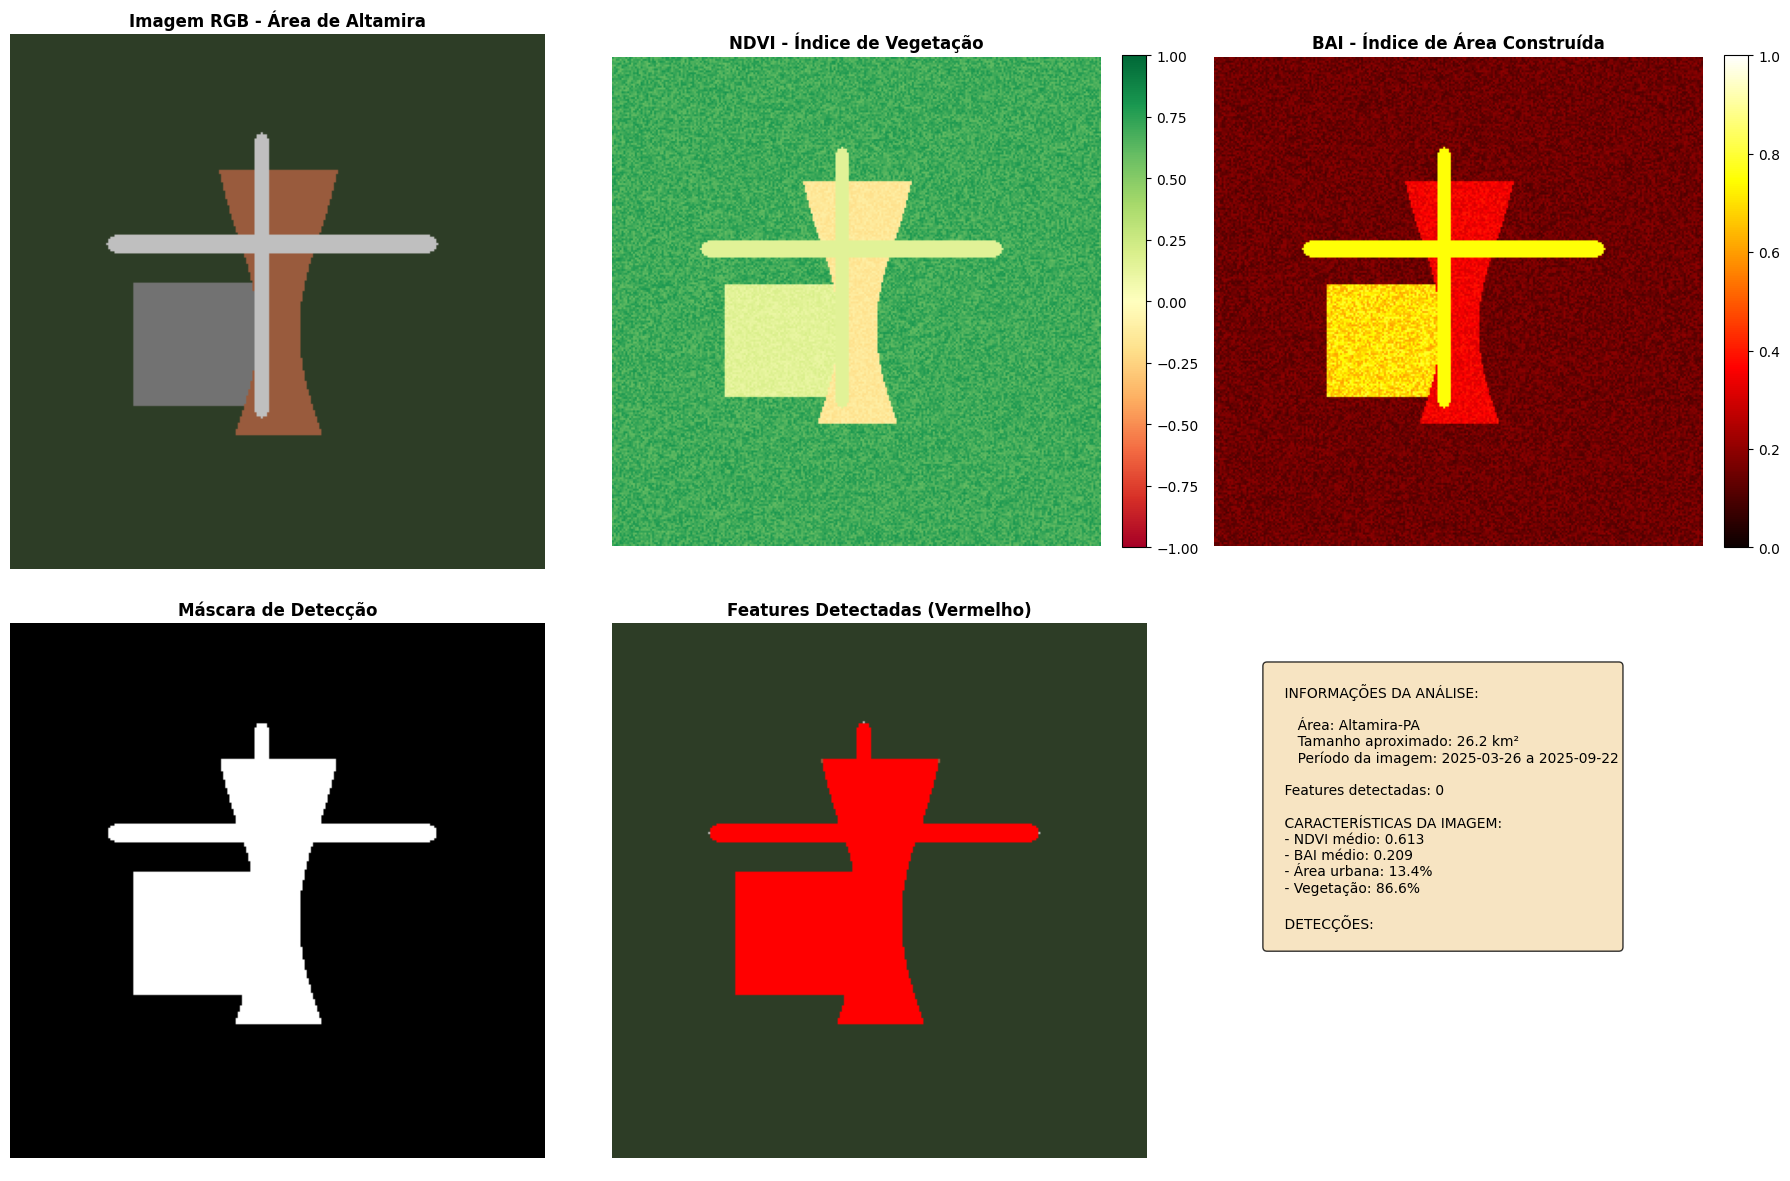

Análise concluída e salva como 'analise_altamira_pistas.png'


In [36]:
# @title Visualização dos Resultados com Dados Reais/Simulados

# Check if image_data and runway_mask are available before attempting visualization
if 'image_data' in locals() and image_data is not None and 'runway_mask' in locals():
    # Criar visualização completa
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Imagem RGB natural
    rgb_image = image_data[:, :, [2, 1, 0]]  # B4, B3, B2 (Red, Green, Blue)
    rgb_normalized = np.clip(rgb_image * 3.0, 0, 1)
    axes[0, 0].imshow(rgb_normalized)
    axes[0, 0].set_title('Imagem RGB - Área de Altamira', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')

    # 2. NDVI
    ndvi_image = image_data[:, :, 5]
    im_ndvi = axes[0, 1].imshow(ndvi_image, cmap='RdYlGn', vmin=-1, vmax=1)
    axes[0, 1].set_title('NDVI - Índice de Vegetação', fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')
    plt.colorbar(im_ndvi, ax=axes[0, 1], fraction=0.046, pad=0.04)

    # 3. BAI
    bai_image = image_data[:, :, 6]
    im_bai = axes[0, 2].imshow(bai_image, cmap='hot', vmin=0, vmax=1)
    axes[0, 2].set_title('BAI - Índice de Área Construída', fontsize=12, fontweight='bold')
    axes[0, 2].axis('off')
    plt.colorbar(im_bai, ax=axes[0, 2], fraction=0.046, pad=0.04)

    # 4. Máscara de detecção
    axes[1, 0].imshow(runway_mask, cmap='gray')
    axes[1, 0].set_title('Máscara de Detecção', fontsize=12, fontweight='bold')
    axes[1, 0].axis('off')

    # 5. Resultado sobreposto
    overlay = rgb_normalized.copy()
    overlay[runway_mask == 1] = [1, 0, 0]  # Destacar em vermelho

    # Desenhar contornos das detecções
    if 'runway_regions' in locals(): # Check if runway_regions was successfully created
        for region in runway_regions:
            cv2.drawContours(overlay, [region['contour']], -1, (0, 1, 1), 2)

    axes[1, 1].imshow(overlay)
    axes[1, 1].set_title('Features Detectadas (Vermelho)', fontsize=12, fontweight='bold')
    axes[1, 1].axis('off')

    # 6. Legenda e informações
    axes[1, 2].axis('off')

    # Use the correct area size based on whether real data was loaded or example data is used
    if image_data_real is not None:
        analysis_area_km2 = (image_data_real.shape[0] * 20) * (image_data_real.shape[1] * 20) / 1000000
    else:
        analysis_area_km2 = (height * 20) * (width * 20) / 1000000 # Use example data dimensions


    info_text = f"""
    INFORMAÇÕES DA ANÁLISE:

       Área: Altamira-PA
       Tamanho aproximado: {analysis_area_km2:.1f} km²
       Período da imagem: {start_date} a {end_date}

    """
    if 'runway_regions' in locals(): # Check if runway_regions was successfully created
        info_text += f"Features detectadas: {len(runway_regions)}\n"
    else:
         info_text += f"Features detectadas: N/A (Erro na detecção)\n"


    if image_data_real is not None:
         info_text += f"""
    CARACTERÍSTICAS DA IMAGEM:
    - NDVI médio: {ndvi_image.mean():.3f}
    - BAI médio: {bai_image.mean():.3f}
    - Área urbana: {np.sum(ndvi_image < 0.2) / ndvi_image.size * 100:.1f}%
    - Vegetação: {np.sum(ndvi_image > 0.6) / ndvi_image.size * 100:.1f}%

    DETECÇÕES:
    """
         if 'runway_regions' in locals(): # Check if runway_regions was successfully created
            for i, region in enumerate(runway_regions[:3]):  # Mostrar até 3 detecções
                info_text += f"\n{i+1}. Aspect ratio: {region['aspect_ratio']:.1f}"
         else:
             info_text += "\nN/A (Erro na detecção)"

    else:
         info_text += """
    CARACTERÍSTICAS DA IMAGEM:
    N/A (Dados reais não carregados)
    """
         if 'runway_regions' in locals(): # Check if runway_regions was successfully created
             info_text += "\nDETECÇÕES:\n"
             for i, region in enumerate(runway_regions[:3]):  # Mostrar até 3 detecções
                 info_text += f"\n{i+1}. Aspect ratio: {region['aspect_ratio']:.1f}"
         else:
             info_text += "\nDETECÇÕES:\nN/A (Erro na detecção)"


    axes[1, 2].text(0.1, 0.9, info_text, transform=axes[1, 2].transAxes,
                    verticalalignment='top', fontsize=10,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    plt.savefig('analise_altamira_pistas.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("Análise concluída e salva como 'analise_altamira_pistas.png'")
else:
    print("Não foi possível gerar a visualização. Dados da imagem ou máscara não disponíveis.")